Portions of the code below were generated with the assistance of GitHub Copilot.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def setar(N, sigma=1.0, x0=0.0, seed=42):
    rng = np.random.default_rng(seed)
    eps = rng.normal(0.0, sigma, size=N)
    X = np.empty(N)
    X[0] = x0
    for t in range(1, N):
        if X[t-1] <= 0:
            X[t] = 0.5 + 0.7 * X[t-1] + eps[t]
        else:
            X[t] = -0.5 - 0.5 * X[t-1] + eps[t]
    return X

In [3]:
def M_theo(x):
    x = np.asarray(x)
    return np.where(x <= 0, 0.5 + 0.7*x, -0.5 - 0.5*x)

In [4]:
# antiderivatives 
F1 = lambda u: 0.5*u + 0.35*u**2      
F2 = lambda u: -0.5*u - 0.25*u**2    

In [ ]:
def cumulative_M(x, a_anchor):
    x = np.asarray(x)
    out = np.empty_like(x, dtype=float)
    for k, xv in enumerate(x):
        if xv <= 0:
            if a_anchor <= 0:
                out[k] = F1(xv) - F1(a_anchor)
            else:
                out[k] = (F2(0) - F2(a_anchor)) + (F1(xv) - F1(0))
        else:
            if a_anchor <= 0:
                out[k] = (F1(0) - F1(a_anchor)) + (F2(xv) - F2(0))
            else:
                out[k] = F2(xv) - F2(a_anchor)
    return out

In [10]:
# cumulative means via histogram 
def cumulative_means_histogram(X, n_bins=20, bin_range=(-2, 2), c_alpha=1.273, min_per_bin=5):
    Xt, Ytp = X[:-1], X[1:]
    a, b = bin_range
    h = (b - a) / n_bins
    breaks = np.linspace(a, b, n_bins + 1)
    centers = a + (np.arange(n_bins) + 0.5) * h

    lam = np.zeros(n_bins)     
    gamma = np.zeros(n_bins)   
    f_hat = np.zeros(n_bins)   

    
    for i in range(n_bins):
        left, right = breaks[i], breaks[i+1]
        if i == 0:
            mask = (Xt >= left) & (Xt <= right)
        else:
            mask = (Xt > left) & (Xt <= right)
        n_i = mask.sum()
        if n_i < min_per_bin:
            raise ValueError(
                f"Bin {i} has only {n_i} points. "
                f"Increase N, shrink n_bins, or widen bin_range."
            )
        ybin = Ytp[mask]
        lam[i] = ybin.mean()
        f_hat[i] = (n_bins * h) ** (-1) * n_i
        gamma[i] = np.sum((ybin - lam[i])**2) / n_i

    # cumulative mean and H
    Lambda = np.cumsum(lam * h)
    h_hat = gamma / f_hat
    H_hat = np.cumsum(h_hat * h)

    # 95% band: 
    H_b = H_hat[-1]
    band_scale = c_alpha * (n_bins ** -0.5) * (H_b ** 0.5)
    Lambda_lower = Lambda - band_scale * (1 + H_hat / H_b)
    Lambda_upper = Lambda + band_scale * (1 + H_hat / H_b)

    return centers, Lambda, Lambda_lower, Lambda_upper, breaks

In [ ]:
# run 
N = 1000
X = setar(N, sigma=1.0, x0=0.0, seed=42)

n_bins = 20
bin_range = (-2, 2)
c_alpha = 1.273

x_c, Lambda, L_low, L_up, breaks = cumulative_means_histogram(
    X, n_bins=n_bins, bin_range=bin_range, c_alpha=c_alpha, min_per_bin=5
)

# theoretical cumulative
L_theo = cumulative_M(x_c, a_anchor=bin_range[0])



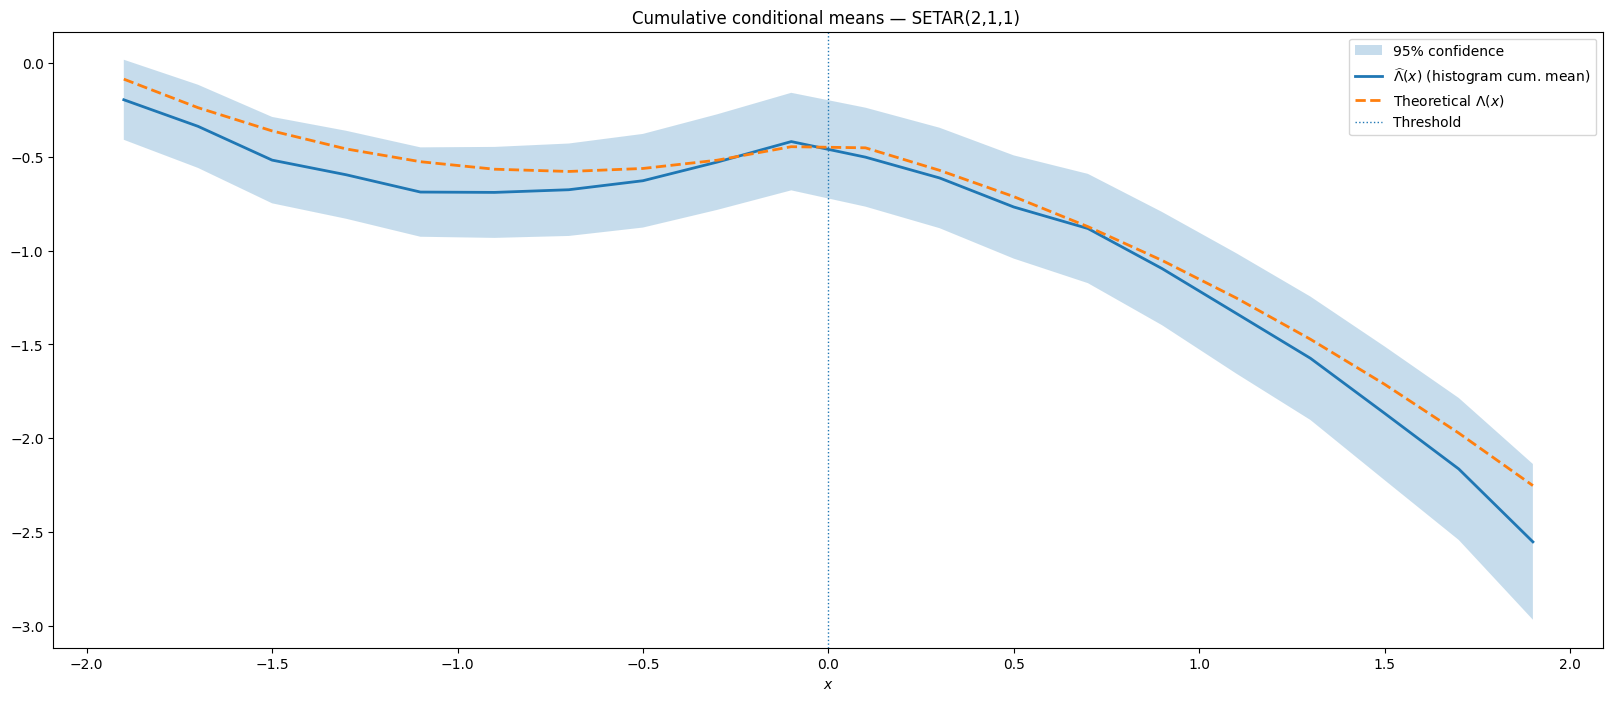

Right-end values  |  Λ_hat: -2.5522   Λ_theo: -2.2525
Band at right end |  [-2.9672, -2.1373]


In [12]:
# plot 
fig, ax = plt.subplots(figsize=(20, 8))
ax.fill_between(x_c, L_low, L_up, alpha=0.25, label='95% confidence')
ax.plot(x_c, Lambda, lw=2, label=r'$\widehat{\Lambda}(x)$ (histogram cum. mean)')
ax.plot(x_c, L_theo, lw=2, ls='--', label=r'Theoretical $\Lambda(x)$')
ax.axvline(0.0, ls=':', lw=1, label='Threshold')
ax.set_title('Cumulative conditional means — SETAR(2,1,1) ')
ax.set_xlabel(r'$x$')
ax.legend()
plt.show()

print(f"Right-end values  |  Λ_hat: {Lambda[-1]:.4f}   Λ_theo: {L_theo[-1]:.4f}")
print(f"Band at right end |  [{L_low[-1]:.4f}, {L_up[-1]:.4f}]")